In [1]:
import os
import yaml
import pickle
import matplotlib

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.pyplot as plt
import bilby
import setproctitle
import pandas as pd
from threadpoolctl import threadpool_limits
from pprint import pprint
from bilby.gw.detector import PowerSpectralDensity
from bilby.gw.detector import InterferometerList

matplotlib.use("pdf")

os.environ["MPLCONFIGDIR"] = "/home/local/nihargupte"
import dingo.gw.dataset.generate_dataset
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import *
from dingo.gw.gwutils import get_window_factor
from dingo.gw.inference import injection
from dingo.core.models import PosteriorModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-toja9i8o because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [57]:
# How we are setting data with dingo: 

approximant = "SEOBNRv4HM_ROM"
special = "_O1_2048_lr"
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"
train_dir = models_dir + f"/train_dir_{approximant}{special}"

with open(train_dir + "/metadata.yaml", "r") as f:
    metadata = yaml.safe_load(f)
    
injection_generator = injection.Injection.from_posterior_model_metadata(metadata)

# Opening up a asd
# NOTE HARD CODING WHERE THE ASD IS STORED SINCE IT WAS MOVED
asd_dataset = ASDDataset(file_name= "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5")
asd = asd_dataset.sample_random_asds()
for ifo_name in asd.keys():
    asd[ifo_name] = np.zeros(asd[ifo_name].shape)
injection_generator.asd = asd
injection_generator.whiten = False

# GW150914 intrinsic mass
intrinsic_parameters = {
    # intrinsic parameters
    "mass_1": 40.0,
    "mass_2": 31.6,
    "chi_1": 0,
    "chi_2": 0,
    "phase": 0,  # rad
    "theta_jn": np.pi/3,  # rad inclination to maximize effect of higher modes
}

extrinsic_parameters = {
    "psi": 0,  # rad
    "ra": 0,  # rad
    "dec": 0,  # rad
    "geocent_time": metadata["train_settings"]["data"]["ref_time"],  # s
    "luminosity_distance": 410,  # Mpc
}
theta = {**intrinsic_parameters, **extrinsic_parameters}

domain = build_domain_from_model_metadata(metadata)
strain_data = injection_generator.injection(theta)

strain_data["parameters"] = theta

# In[8]:
ifo_strs = ["H1", "L1"]
dingo_ifos = InterferometerList(ifo_strs)
for ifo in dingo_ifos:
    asd_array = strain_data["asds"][ifo.name]
    # This step is actually very important
    asd_array = asd_array.astype("float64")
    x_freq = domain.sample_frequencies.astype("float64")
    psd = PowerSpectralDensity(frequency_array=x_freq, asd_array=asd_array)
    ifo.power_spectral_density = psd
    # Making sure we aren't dropping anything due to precision
    # assert np.min(asd_array**2) > 0
    ifo.set_strain_data_from_frequency_domain_strain(
        strain_data["waveform"][ifo.name], frequency_array=x_freq
    )
    # ifo.strain_data.window_factor = domain.window_factor


Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.


In [58]:
sampling_frequency = 4096.0
duration = 8.0

# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='SEOBNRv4HM_ROM',
                          reference_frequency=20., minimum_frequency=20.)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
bilby_ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in bilby_ifos:
    psd = PowerSpectralDensity(frequency_array=x_freq, asd_array=asd_array)
    ifo.power_spectral_density = psd
    ifo.set_strain_data_from_power_spectral_density(sampling_frequency, duration)
bilby_ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=theta)


/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/bilby/gw/utils.py:217: RuntimeWarning: divide by zero encountered in true_divide
  integrand = np.conj(aa) * bb / power_spectral_density
/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/bilby/gw/utils.py:217: RuntimeWarning: invalid value encountered in true_divide
  integrand = np.conj(aa) * bb / power_spectral_density
/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/bilby/gw/utils.py:245: RuntimeWarning: invalid value encountered in cdouble_scalars
  rho_mf /= optimal_snr_squared(


[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

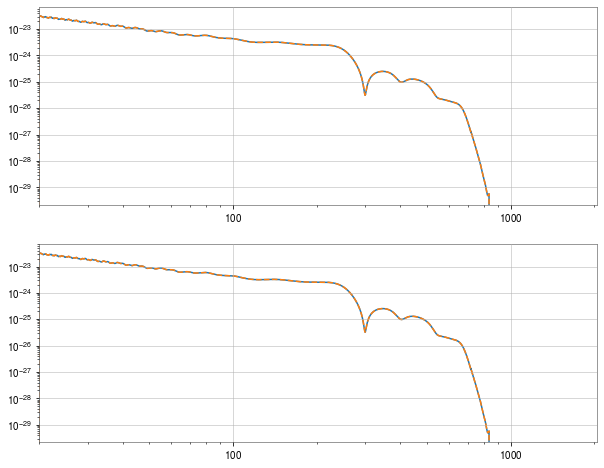

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i in range(len(ifo_strs)):
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlim([20, 2048])
    axes[i].plot(dingo_ifos[i].frequency_array, np.abs(dingo_ifos[i].frequency_domain_strain))
    axes[i].plot(bilby_ifos[i].frequency_array, np.abs(bilby_ifos[i].frequency_domain_strain), linestyle="--")

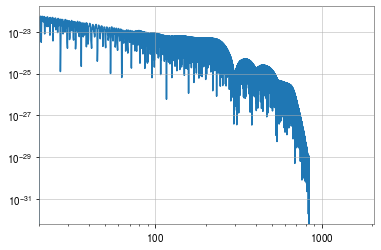

In [73]:
diff_ifo = [np.abs(dingo_ifos[i].frequency_domain_strain - bilby_ifos[i].frequency_domain_strain) for i in [0, 1]]
plt.xlim([20, 2048])
plt.xscale('log')
plt.yscale('log')
plt.plot(domain.sample_frequencies, diff_ifo[0])

{'mass_1': 40.0, 'mass_2': 31.6, 'chi_1': 0.0, 'chi_2': 0.0, 'phase': 0.0, 'theta_jn': 1.0471975511965976, 'geocent_time': 0.0, 'luminosity_distance': 100.0}


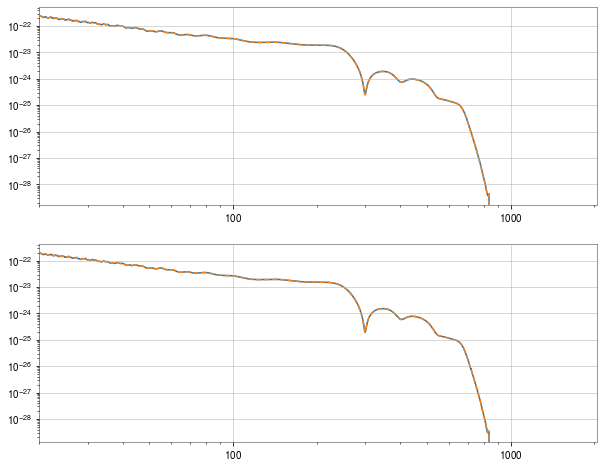

In [56]:
from dingo.gw.prior import split_off_extrinsic_parameters

signal = injection_generator.signal(theta)

theta_intrinsic, theta_extrinsic = split_off_extrinsic_parameters(theta)
theta_intrinsic = {k: float(v) for k, v in theta_intrinsic.items()}
print(theta_intrinsic)

dingo_polarizations = injection_generator.waveform_generator.generate_hplus_hcross(theta_intrinsic)
bilby_polarizations = waveform_generator.frequency_domain_strain(theta_intrinsic)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, (bilby_key, dingo_key) in enumerate(zip(bilby_polarizations.keys(), dingo_polarizations.keys())):
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlim([20, 2048])
    axes[i].plot(domain.sample_frequencies, np.abs(dingo_polarizations[dingo_key]))
    axes[i].plot(domain.sample_frequencies, np.abs(bilby_polarizations[bilby_key]), linestyle='--')

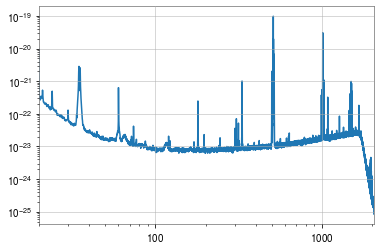

In [67]:
plt.xlim([20, 2048])
plt.xscale('log')
plt.yscale('log')
plt.plot(x_freq, asd_array)